# CUSUM trading techniques for Cryptos

## 1. Lam and Yam (1997)
CUSUM based filter trading strategy.

### Load data
Watch list: top nine cryptocurrencies (ranked by market capitalization) plus Dogecoin, as of November 2021
+ Bitcoin, Ethereum, Solana, Ripple, Binance Coin, Tether, Cardano, Polkadot, Terra, Dogecoin

In [85]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# just set the seed for the random number generator
np.random.seed(107)

plt.rcParams['figure.figsize'] = (16, 9)

In [86]:
cryptos = pd.read_csv("../data/crypto_1y.csv", parse_dates=True, index_col="time")
cryptos.head()

,BTC,ETH,SOL,XRP,BNB,USDT,ADA,DOT,LUNA,DOGE
time,,,,,,,,,,
2020-11-01 01:00:00,13770.78,389.16,1.556,0.2403,28.59,1.002,0.09378,4.194,0.3030,0.002549
2020-11-01 02:00:00,13721.73,387.91,1.553,0.2393,28.39,1.002,0.09374,4.193,0.3011,0.002570
2020-11-01 03:00:00,13700.10,386.75,1.534,0.2392,28.40,1.002,0.09355,4.177,0.3013,0.002574
2020-11-01 04:00:00,13683.91,386.57,1.529,0.2391,28.23,1.002,0.09338,4.157,0.3002,0.002567
2020-11-01 05:00:00,13705.51,386.08,1.531,0.2391,28.27,1.002,0.09315,4.143,0.3006,0.002611


### Generalized CUSUM filter rule

For simplicity, we do not allow short thus we always start by detecting a buy signal. Then we try to detect sell signal after a buy signal.

To do later:
1. Find optimal k, h value
2. Optimize plots
3. Backtest

In [87]:
# should test for an optimal k, h
k = 0.0005
h = 10*k

def calculateReturn(df, coin: str):
    df.loc[:, "price"] = df.loc[:, coin]
    df.loc[:, "logPrice"] = np.log(df.loc[:, "price"])
    df.loc[:, "return"] = df.loc[:, "logPrice"] - df.loc[:, "logPrice"].shift(1)
    
    df.loc[df.index[0], "return"] = 0
    df.loc[df.index[0], 'signal'] = 0
    cols = ['price', 'logPrice', 'return', 'signal']
    return df.loc[:, cols]


def detectSellSignal(df, start):
    df.loc[df.index[start], 'cMinus'] = 0
    for i in range(start+1, len(df)):
        cMinus = np.min([0, df.loc[df.index[i-1], 'cMinus'] + df.loc[df.index[i], 'return']-k])
        df.loc[df.index[i], 'cMinus'] = cMinus
        
        if cMinus <= -h:
            # sell signal appears
            df.loc[df.index[i], 'signal'] = -1
            return detectBuySignal(df, i)
        else:
            df.loc[df.index[i], 'signal'] = 0
            
    return df


def detectBuySignal(df, start):
    df.loc[df.index[start], "cPlus"] = 0
    for i in range(start+1, len(df)):
        cPlus = np.max([0, df.loc[df.index[i-1], 'cPlus'] + df.loc[df.index[i], 'return']-k])
        df.loc[df.index[i], 'cPlus'] = cPlus
        
        if cPlus >= h:
            # buy signal appears
            df.loc[df.index[i], 'signal'] = 1
            return detectSellSignal(df, i)
        else:
            df.loc[df.index[i], 'signal'] = 0
            
    return df


def createTradeSignal(df):
    return detectBuySignal(df, start=0)

In [88]:
df = (cryptos
      .pipe(calculateReturn, "BTC")
      .pipe(createTradeSignal))

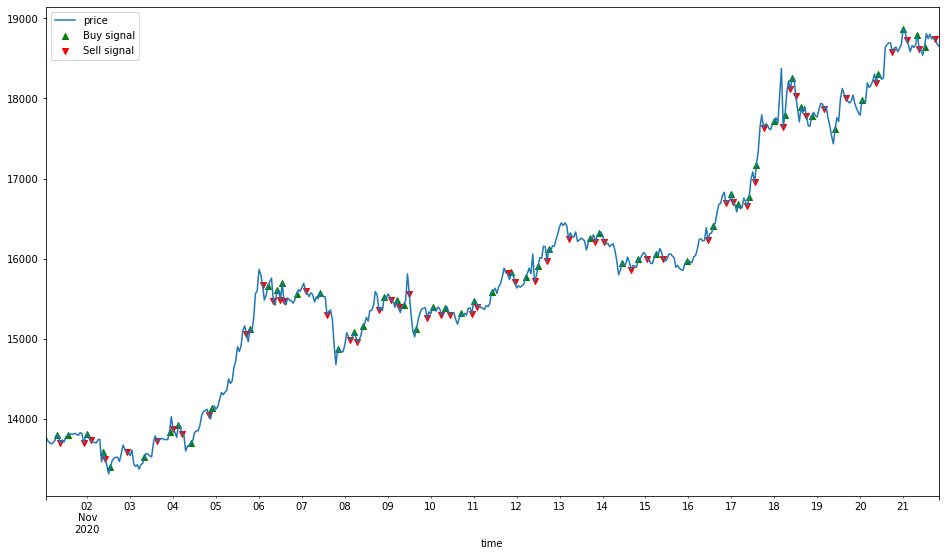

In [212]:
def plotPriceWithSignal(df):
    # optimze looking later
    df.loc[:, 'price'].plot()
    buy = df.loc[df['signal']==1, 'price']
    plt.scatter(buy.index, buy, c="g", marker="^", label="Buy signal")
    sell = df.loc[df['signal']==-1, 'price']
    plt.scatter(sell.index, sell, c="r", marker="v", label="Sell signal")
    plt.legend(loc='best')
    plt.show()
    
plotPriceWithSignal(df.head(500))

In [36]:
# calculate profit
buyPrice = df.loc[df['signal']==1, 'price']
sellPrice = df.loc[df['signal']==-1, 'price']
buyPriceEven = buyPrice[:len(sellPrice)]
np.sum((sellPrice.values-buyPriceEven.values)/buyPriceEven.values)

0.7931945540974522

## 2. Yi *et al* (2006)

In [ ]:
## performance of the trading cycle can be measured by DailyProfit and TotalProfit (w/wo transaction fees)

In [216]:
TPi=[]
for i,j in zip(buyPriceEven, sellPrice):
    TPi.append((j/i))
TP=np.prod(TPi)
TP

1.8511050504986943

In [121]:
date=[]
for i in df.index:
    date.append(i)
df['date']=date

buyTime = df.loc[df['signal']==1, "date"]
sellTime = df.loc[df['signal']==-1, "date"]
buyTimeEven = buyTime[:len(sellTime)]

Di=[]
for i,j in zip(buyTimeEven, sellTime):
    Di.append(j-i)
D=np.sum(Di)
H = (D.days)*24+ (D.seconds//3600)
#print("Total Hours:", H)

DP=(TP-1)/H
print("Hourly Profit before considering transaction fees is:", DP)

Total Hours: 4202


Hourly Profit is: 0.0002025476084004508


In [126]:
## Considering transaction fees:
alpha=0.005
TP2=TP*(1-alpha)**(2*len(buyTimeEven))
DP2=(TP2-1)/H
print("TP after transaction fee taking into account:", TP2, '\n', "Hourly Profit after transaction fee taking into account:", DP2)

TP after transaction fee taking into account: 1.5363901927062084e-05 
 Hourly Profit after transaction fee taking into account: -0.00023797825704380604


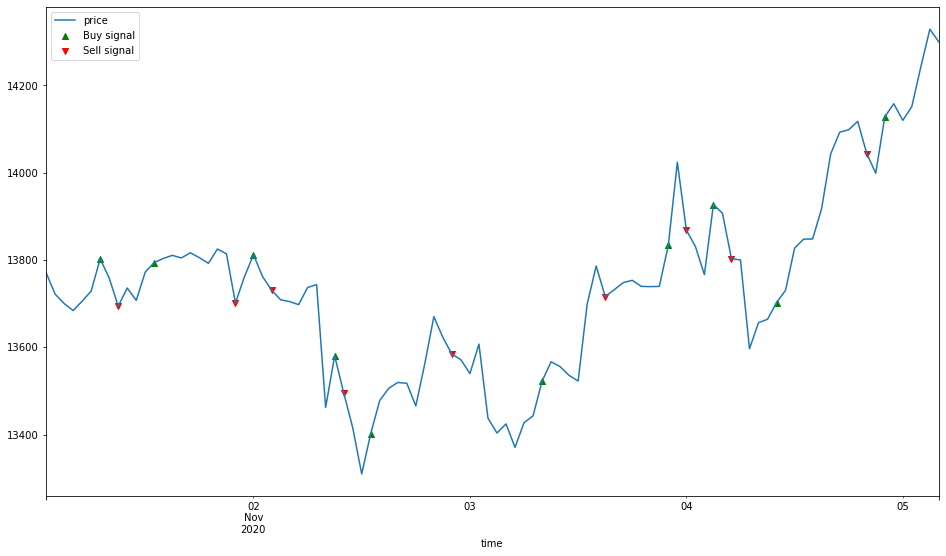

In [176]:
def plotPriceWithSignal(df):
    # optimze looking later
    df.loc[:, 'price'].plot()
    buy = df.loc[df['signal']==1, 'price']
    plt.scatter(buy.index, buy, c="g", marker="^", label="Buy signal")
    sell = df.loc[df['signal']==-1, 'price']
    plt.scatter(sell.index, sell, c="r", marker="v", label="Sell signal")
    plt.legend(loc='best')
    plt.show()
    
plotPriceWithSignal(df.head(100))

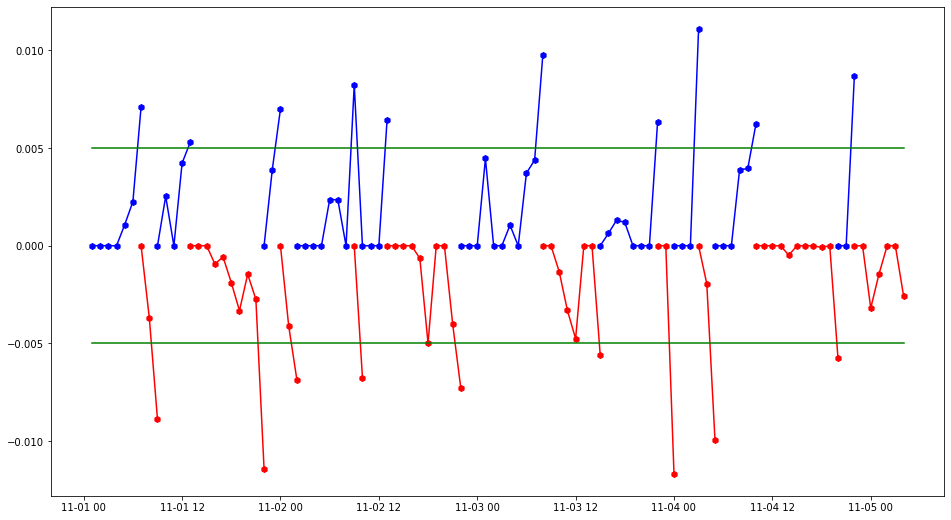

In [175]:
def CUSUMPlot(df):
    plt.plot(df.index,df['cPlus'], color='b', marker='h', markersize=6)
    plt.plot(df.index,df['cMinus'], color='r', marker='h', markersize=6)
    plt.plot(df.index,np.array([h]*len(df.index)),color='g')
    plt.plot(df.index,np.array([-h]*len(df.index)),color='g')
    plt.show()
CUSUMPlot(df.head(100))

In [ ]:
# Plot Total Profit / Hourly Profit for different K's for scenarios: with and without transaction fees.

## 3. Žmuk (2016)

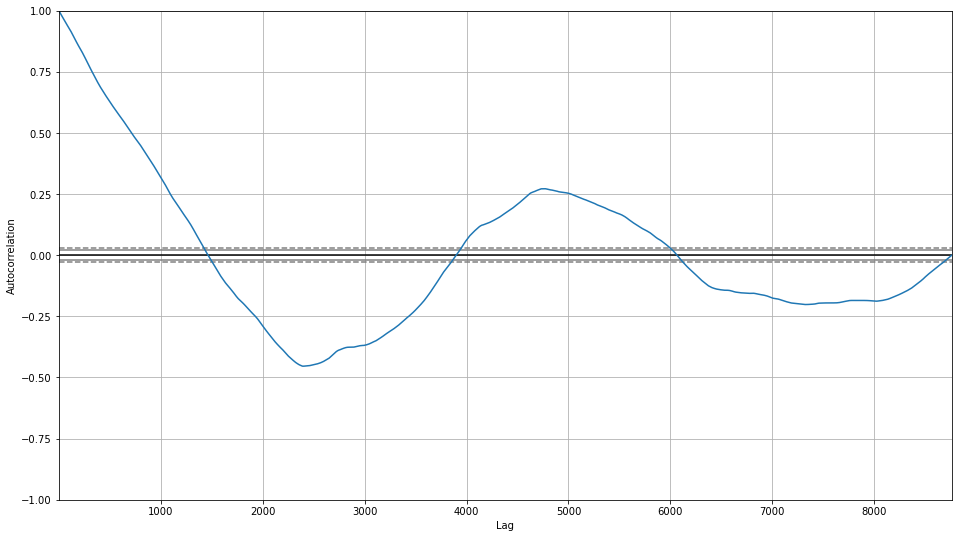

In [198]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(cryptos['BTC'])
plt.show()

In [200]:
#corr = cryptos.corr()
#sns.heatmap(corr, annot=True, linewidth=.01)
#plt.show()

In [ ]:
#p is the order of the AR term
#q is the order of the MA term
#d is the number of differencing required to make the time series stationary

#p: The number of lag observations included in the model, also called the lag order.
#d: The number of times that the raw observations are differenced, also called the degree of differencing.
#q: The size of the moving average window, also called the order of moving average.

In [209]:
#AR parameter = 700
from statsmodels.tsa.arima.model import ARIMA
dart 
model = ARIMA(cryptos['BTC'], order=(1,1,0))
model_fit = model.fit()

C:\Users\babak\anaconda3\envs\Pandas\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\babak\anaconda3\envs\Pandas\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\babak\anaconda3\envs\Pandas\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


                               SARIMAX Results                                
Dep. Variable:                    BTC   No. Observations:                 8760
Model:                 ARIMA(1, 1, 0)   Log Likelihood              -64593.805
Date:                Mon, 29 Nov 2021   AIC                         129191.610
Time:                        15:11:14   BIC                         129205.765
Sample:                    11-01-2020   HQIC                        129196.433
                         - 11-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0047      0.007     -0.687      0.492      -0.018       0.009
sigma2      1.489e+05    927.031    160.674      0.000    1.47e+05    1.51e+05
Ljung-Box (Q):                      120.85   Jarque-

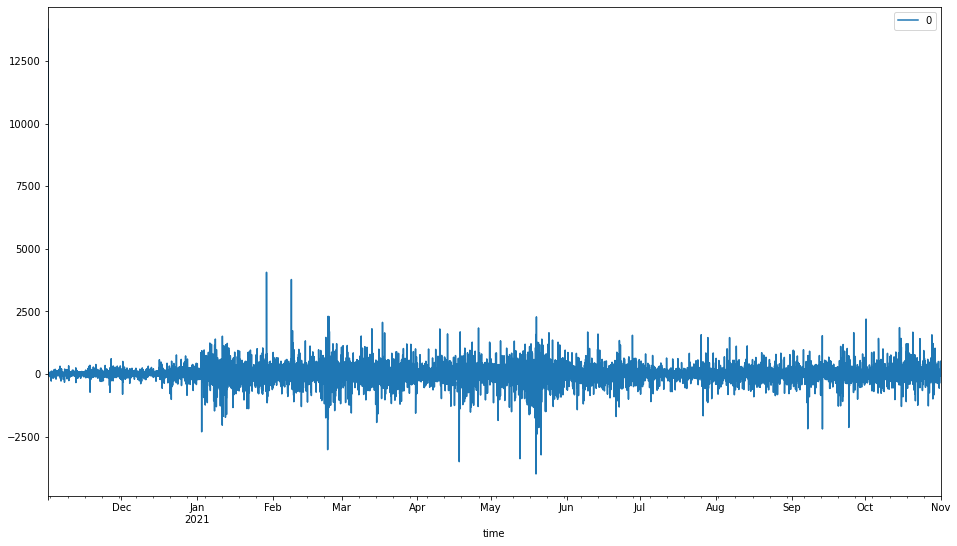

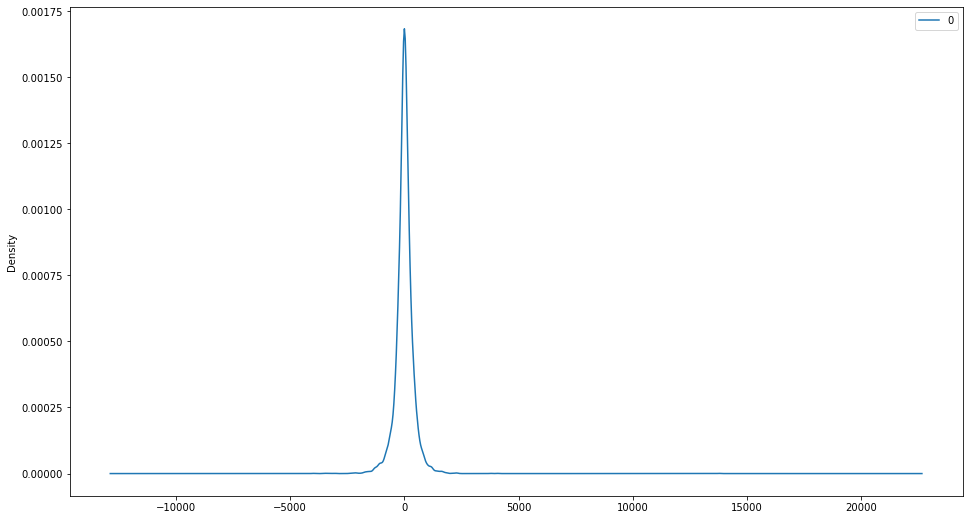

                  0
count   8760.000000
mean       7.059102
std      412.956682
min    -3990.576042
25%     -156.952843
50%        7.368687
75%      176.467514
max    13770.780000


In [210]:
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

In [218]:
residuals = pd.DataFrame(model_fit.resid)

In [220]:
residuals

,0
time,
2020-11-01 01:00:00,13770.780000
2020-11-01 02:00:00,-40.595920
2020-11-01 03:00:00,-21.862274
2020-11-01 04:00:00,-16.292428
2020-11-01 05:00:00,21.523333
...,...
2021-10-31 20:00:00,231.620255
2021-10-31 21:00:00,514.637203
2021-10-31 22:00:00,-63.598159


,price,logPrice,return,signal,cPlus,cMinus,date
time,,,,,,,
2020-11-01 01:00:00,13770.78,9.530304,0.000000,0.0,0.000000,NaN,2020-11-01 01:00:00
2020-11-01 02:00:00,13721.73,9.526736,-0.003568,0.0,0.000000,NaN,2020-11-01 02:00:00
2020-11-01 03:00:00,13700.10,9.525158,-0.001578,0.0,0.000000,NaN,2020-11-01 03:00:00
2020-11-01 04:00:00,13683.91,9.523976,-0.001182,0.0,0.000000,NaN,2020-11-01 04:00:00
2020-11-01 05:00:00,13705.51,9.525553,0.001577,0.0,0.001077,NaN,2020-11-01 05:00:00
...,...,...,...,...,...,...,...
2021-10-31 20:00:00,60969.55,11.018130,0.003807,1.0,0.006874,0.000000,2021-10-31 20:00:00
2021-10-31 21:00:00,61483.09,11.026517,0.008388,0.0,NaN,0.000000,2021-10-31 21:00:00
2021-10-31 22:00:00,61417.06,11.025443,-0.001075,0.0,NaN,-0.001575,2021-10-31 22:00:00
